In [26]:
from matplotlib import pyplot as plt

import torch
from torch import nn

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

from torchvision.transforms.functional import to_pil_image

In [32]:
train_data = datasets.ImageFolder('data/fruits-100/train/',
                                  transform=ToTensor())

In [12]:
dl = DataLoader(train_data)

tensor([0])


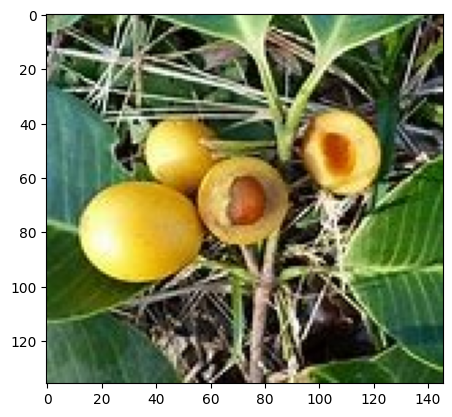

In [30]:
for d in dl:
    # print(d[0].squeeze().shape)
    plt.imshow(ToPILImage()(d[0].squeeze()))
    print(d[1])
    break